# *Thermal Transport in a Cylinder*

In this demo, we solve the three-dimensional diffusion equation in a short
cylinder, with Dirichlet boundary conditions $u_D$ and steady source term
$f$ along the central axis.

$$
\begin{align}
  u'   &= \nabla^2 u + f     \quad\text{in a short cylinder} \\
  u    &= u_D  \hphantom{u+f}\quad\text{on the boundary} \\
  u    &= u_0  \hphantom{u+f}\quad\;\text{at $t = 0$}
\end{align}
$$
with$$
\begin{align}
  u_D  &= 0 \\
  u_0  &= 0 \\
  f    &= A \exp\bigl( -(r/\rho)^2 - (z/\zeta)^2 \bigr).
\end{align}
$$

In [1]:
import numpy as np
from fenics import *
from mshr import *   # now deprecated (?), transition to alternate mesh generator (?)

In [2]:
## set up the problem and define (some of) the main parameters

# simulation parameters
# -- time step
T = 5.0           # total simulation time
n_steps = 100     # number of time steps
dt = T / n_steps  # size of time step
nip = 10          # number of intervals between plots
# -- cylinder
rad = 1.0         # radius
lh  = 0.1         # half-length
# --  mesh density
md = 24           # mesh density within cylinder

# create mesh: Cylinder(p_top, p_bot, r_top, r_bot)
domain = Cylinder(Point(0, 0, lh), Point(0., 0., -lh), rad, rad)
mesh = generate_mesh(domain, md)
# and define function space
V = FunctionSpace(mesh, 'P', 1)

Generating mesh with CGAL 3D mesh generator


In [3]:
mesh

In [4]:
# define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# define initial value
u_0 = Constant(0)
u_n = interpolate(u_0, V)

# define source term
A = 2.0          # amplitude
rho =  rad / 10  # radial decay length
zeta = lh / 2    # longitudinal decay length
f = Expression('A * exp( -(pow(x[0], 2) + pow(x[1], 2)) / pow(rho, 2) - pow(x[2] / zeta, 2) )',
               degree=1, A=A, rho=rho, zeta=zeta)

# define the variational problem
u = TrialFunction(V)
v = TestFunction(V)
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

In [5]:
# define time-evolution function
def evolve():

    # report initial state
    yield u_n

    # time-stepping
    u = Function(V)
    t = 0
    for n in range(1, n_steps + 1):

        # update current time
        t += dt

        # compute solution
        solve(a == L, u, bc)

        # report solution at nip-step intervals
        if n % nip == 0:
            yield u

        # update previous solution
        u_n.assign(u)

In [6]:
n_rows = 3
n_cols = 5
fig_wd = 15
# default sizing here yields unit aspect ratio
# plt.figure(figsize = (fig_wd, fig_wd * n_rows // n_cols))

idx = 0
for u in evolve():
    idx += 1
#     plot(u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear v

In [7]:
xvals = mesh.coordinates()[:,0]
yvals = mesh.coordinates()[:,1]
zvals = mesh.coordinates()[:,2]
uvals = u.compute_vertex_values()

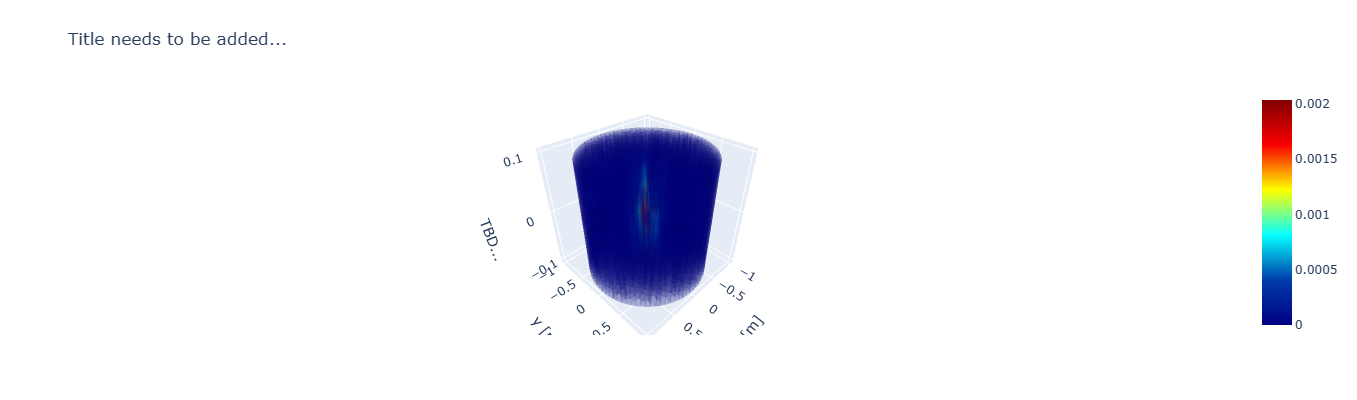

In [11]:
import plotly.graph_objects

inds = []
# get the "facets" and build an array of the indices of their coordinates
for item in dolfin.cpp.mesh.facets(mesh):
    inds.append(item.entities(0).tolist())

# provide these indices to plotly so it can draw proper surfaces
inds = np.array(inds)
ii = inds[:, 0]
jj = inds[:, 1]
kk = inds[:, 2]

fig = plotly.graph_objects.Figure(
    data=[plotly.graph_objects.Mesh3d(
        x=xvals, y=yvals, z=zvals,
        i=ii, j=jj, k=kk,
        colorscale='jet',
        intensity=uvals,
        alphahull=-1,
        opacity=0.1
    )]
)
# fig.update_layout(scene_aspectmode='data')
fig.update_layout(
    title='Title needs to be added...',
    scene = dict(xaxis_title='x [m]', yaxis_title='y [m]', zaxis_title='TBD...'),
    width=800, height=400, autosize=False,
    margin=dict(l=65, r=50, b=65, t=90),
)
fig.show()